In [2]:
import re
import os
import pandas as pd
import numpy as np
import time

#ML model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import sklearn.metrics as metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
# sns.set()

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
df = pd.read_csv('loan.csv', encoding='ISO-8859–1')
df.shape

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260668, 145)

In [4]:
# get information about the number of missing values and their percentage
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(df).head(50)

Your selected dataframe has 145 columns.
There are 113 columns that have missing values.


,Missing Values,% of Total Values
id,2260668,100.0
url,2260668,100.0
member_id,2260668,100.0
orig_projected_additional_accrued_interest,2252242,99.6
hardship_length,2250055,99.5
hardship_reason,2250055,99.5
hardship_status,2250055,99.5
deferral_term,2250055,99.5
hardship_amount,2250055,99.5
hardship_start_date,2250055,99.5


In [5]:
# delete columns with more than 35% NA
df.dropna(thresh=df.shape[0]*0.65,how='all',axis=1,inplace=True)
# delete columns with no value to the analysis
df.drop(['funded_amnt','funded_amnt_inv','policy_code'],axis = 1, inplace = True)

In [6]:
# separate year and month
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['year'] = pd.DatetimeIndex(df['issue_d']).year
df['month'] = pd.DatetimeIndex(df['issue_d']).month
df.drop(['issue_d'],axis =1, inplace =True)

In [7]:
print(df.shape)
df.columns

(2260668, 85)


Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_

In [8]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,year,month
0,2500,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,...,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N,2018,12
1,30000,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,...,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N,2018,12
2,5000,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,...,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N,2018,12
3,4000,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,...,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N,2018,12
4,30000,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,...,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N,2018,12


# EDA

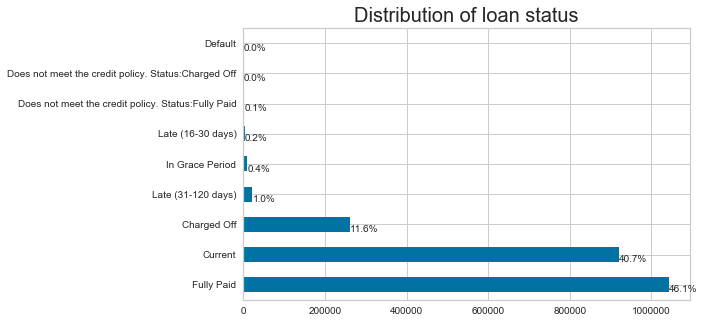

In [9]:
plt.figure(figsize=(8, 5))
ax = df['loan_status'].value_counts().plot(kind='barh')
plt.title('Distribution of loan status',fontsize=20)

total = len(df['loan_status'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width()+100
        y = p.get_y()
        ax.annotate(percentage, (x, y))

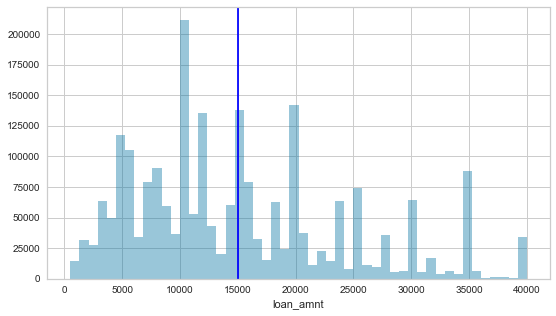

In [10]:
plt.figure(figsize=(9, 5))
sns.distplot(df['loan_amnt'],kde = False)
plt.axvline(df['loan_amnt'].mean(), 0,1,color = 'blue')

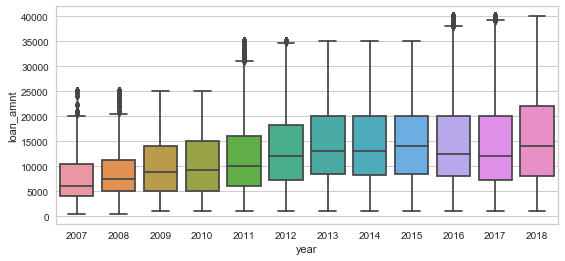

In [11]:
plt.figure(figsize=(9, 4))
sns.boxplot(x = 'year',y = 'loan_amnt',data =df)

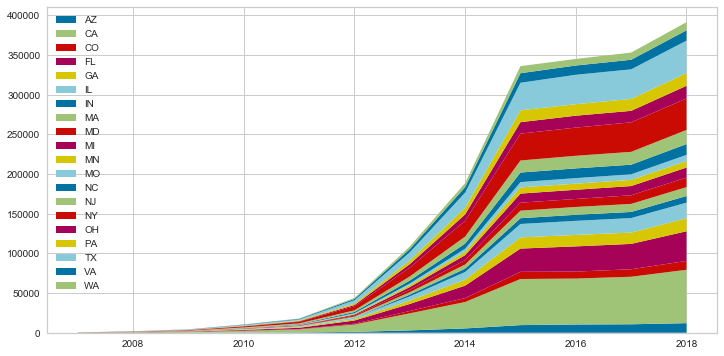

In [12]:
df_top_states = df[df['addr_state'].isin(df['addr_state'].value_counts().head(20).index)]
state_pivot = pd.pivot_table(df_top_states, index=['addr_state'],
                         columns=['year'],
                         values=['loan_amnt'], 
                         aggfunc = lambda x: len(x), 
                         fill_value=0)
fig= plt.figure(figsize = (12,6))
year_list = sorted(df_top_states['year'].unique())
plt.stackplot(year_list,state_pivot.values, labels = state_pivot.index)
plt.legend(loc='upper left')

In [13]:
#df2, select columns according to importance
df2=df[['loan_status','loan_amnt','term','grade','emp_length',
'home_ownership','annual_inc','dti','open_acc','revol_bal',
'revol_util','total_acc','int_rate','acc_now_delinq']]
#df2, select rows (charged off, defualt, fully paid
df2 =df2[df2['loan_status'].isin(['Fully Paid', 'Charged Off','Default'])]
df2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303638 entries, 100 to 2260664
Data columns (total 14 columns):
loan_status       1303638 non-null object
loan_amnt         1303638 non-null int64
term              1303638 non-null object
grade             1303638 non-null object
emp_length        1228181 non-null object
home_ownership    1303638 non-null object
annual_inc        1303638 non-null float64
dti               1303326 non-null float64
open_acc          1303638 non-null float64
revol_bal         1303638 non-null int64
revol_util        1302828 non-null float64
total_acc         1303638 non-null float64
int_rate          1303638 non-null float64
acc_now_delinq    1303638 non-null float64
dtypes: float64(7), int64(2), object(5)
memory usage: 149.2+ MB


In [14]:
corr = df2.corr()
corr

,loan_amnt,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,int_rate,acc_now_delinq
loan_amnt,1.000000,0.310232,0.032081,0.186320,0.318613,0.108459,0.208991,0.143815,0.001684
annual_inc,0.310232,1.000000,-0.141383,0.133672,0.284175,0.034614,0.174806,-0.071268,0.013480
dti,0.032081,-0.141383,1.000000,0.229020,0.111136,0.143313,0.176408,0.148392,0.003235
open_acc,0.186320,0.133672,0.229020,1.000000,0.223344,-0.141081,0.700441,-0.003866,0.019954
revol_bal,0.318613,0.284175,0.111136,0.223344,1.000000,0.234849,0.191138,-0.027679,0.001457
revol_util,0.108459,0.034614,0.143313,-0.141081,0.234849,1.000000,-0.105596,0.242765,-0.027229
total_acc,0.208991,0.174806,0.176408,0.700441,0.191138,-0.105596,1.000000,-0.042263,0.027375
int_rate,0.143815,-0.071268,0.148392,-0.003866,-0.027679,0.242765,-0.042263,1.000000,0.017496
acc_now_delinq,0.001684,0.013480,0.003235,0.019954,0.001457,-0.027229,0.027375,0.017496,1.000000


/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


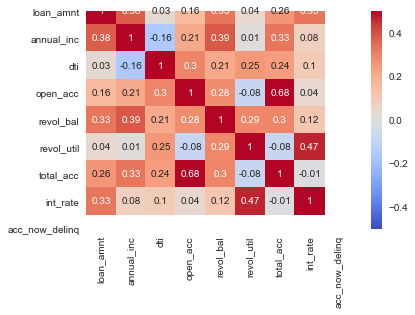

In [15]:
df = pd.read_csv('loan_2.csv')
df = df[df['total_acc'] != 'f']
df = df.dropna()
corr = round(df.corr(),2)
sns.heatmap(corr, annot=True,cmap='coolwarm', vmin=-0.5, vmax=0.5)

In [16]:
col_drop = ['emp_length','total_acc']
df = df.drop(columns = col_drop)

In [19]:
df['term'] = [int(t.split(' ')[1]) for t in df['term']]

AttributeError: 'int' object has no attribute 'split'

In [20]:
# status=pd.concat([loan_s, loan_s2], axis=1)
# status.to_csv(r'loan_status.csv', index=False)

In [21]:
# Data Transformation

In [22]:
y_dict = {'Fully Paid': 1, 'Charged Off': 0, 'Default': 0}
df['loan_status'] = df['loan_status'].map(y_dict)

In [23]:
dtype = pd.DataFrame(df.dtypes)
col = list(dtype[dtype[dtype.columns[0]] == 'object'].index)
df_dummy = pd.get_dummies(df, columns = col)
len(df_dummy[df_dummy['loan_status'] == 1]), len(df_dummy[df_dummy['loan_status'] == 0])

(11920, 2358)

In [34]:
df_minority

,loan_status,loan_amnt,term,annual_inc,dti,open_acc,revol_bal,revol_util,int_rate,acc_now_delinq,...,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1,0,2500,60,30000.0,1.00,3,1687,9.4,15.27,0,...,0,1,0,0,0,0,0,0,0,1
6,0,5600,60,40000.0,5.55,11,5210,32.6,21.28,0,...,0,0,0,0,1,0,0,0,1,0
7,0,5375,60,15000.0,18.08,2,9279,36.5,12.69,0,...,1,0,0,0,0,0,0,0,0,1
10,0,9000,36,30000.0,10.08,4,10452,91.7,13.49,0,...,0,1,0,0,0,0,0,0,0,1
12,0,10000,36,100000.0,7.06,14,11997,55.5,10.65,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14772,0,10000,36,52000.0,3.92,7,9301,44.1,13.43,0,...,0,1,0,0,0,0,0,0,0,1
14774,0,31000,60,75000.0,12.90,10,322,1.7,13.06,0,...,0,1,0,0,0,0,1,0,0,0
14781,0,20000,60,72000.0,8.57,9,5023,34.4,11.11,0,...,1,0,0,0,0,0,0,0,0,1
14792,0,5000,36,36000.0,17.93,5,1592,37.9,10.00,0,...,1,0,0,0,0,0,0,0,1,0


In [36]:
df_minority = df_dummy[df_dummy['loan_status'] == 0]
df_majority = df_dummy[df_dummy['loan_status'] == 1]
df_minority_unsampled = resample(df_minority, replace = True, n_samples = len(df_minority) * 4, random_state = 123)
df_unsampled = pd.concat([df_majority, df_minority_unsampled])
df_unsampled.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21352 entries, 0 to 6925
Data columns (total 21 columns):
loan_status                21352 non-null int64
loan_amnt                  21352 non-null int64
term                       21352 non-null int64
annual_inc                 21352 non-null float64
dti                        21352 non-null float64
open_acc                   21352 non-null int64
revol_bal                  21352 non-null int64
revol_util                 21352 non-null float64
int_rate                   21352 non-null float64
acc_now_delinq             21352 non-null int64
grade_A                    21352 non-null uint8
grade_B                    21352 non-null uint8
grade_C                    21352 non-null uint8
grade_D                    21352 non-null uint8
grade_E                    21352 non-null uint8
grade_F                    21352 non-null uint8
grade_G                    21352 non-null uint8
home_ownership_MORTGAGE    21352 non-null uint8
home_ownership_OTHER

In [37]:
features = df_unsampled.columns[1:]
x = df_unsampled[features]
y = df_unsampled['loan_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, train_size = 0.7)

In [26]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14946, 20), (6406, 20), (14946,), (6406,))

In [27]:
rf = RandomForestClassifier(n_estimators= 100, oob_score=True, random_state=10)
rf.fit(x_train,y_train)
print(rf.oob_score_)
y_predrf = rf.predict_proba(x_test)[:,1]
print("ROC_AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predrf))

0.9249297470895222
ROC_AUC Score (Train): 0.980928


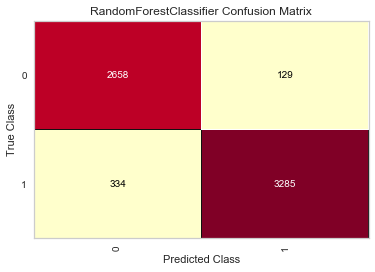

0.9277240087418046

In [28]:
cm = ConfusionMatrix(rf, classes=[0,1])
cm.fit(x_train, y_train)
cm.score(x_test, y_test)
cm.poof()
rf.score(x_test, y_test)

In [29]:
y_predrf = rf.predict(x_test)
print("Classification report for classifier %s:\n%s\n"
      % (rf, metrics.classification_report(y_test, y_predrf)))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2787
           1       0.96      0.91      0.93      3619

    accuracy                           0.93      6406
   macro avg       0.93      0.93      0.93      6406
weighted avg       0.93      0.93      0.93      6406




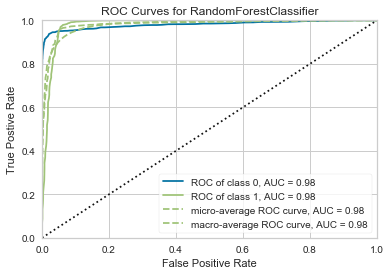

In [30]:
classes=[0,1]
visualizer = ROCAUC(rf, classes=classes)

visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
g = visualizer.poof()

In [31]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(x_train,y_train)
test_pred = logreg.predict(x_test)
train_pred = logreg.predict(x_train)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, test_pred)
cnf_matrix

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[1710, 1077],
       [1188, 2431]])

In [32]:
print ('LF result: %.3f/%.3f' % (roc_auc_score(y_train, train_pred), roc_auc_score(y_test, test_pred)))

NameError: name 'roc_auc_score' is not defined

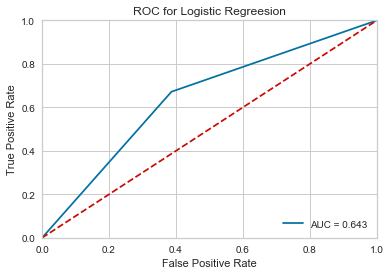

In [33]:
# calculate the fpr and tpr for all thresholds of the classification
test_pred = logreg.predict(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt

plt.title('ROC for Logistic Regreesion')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()